In [ ]:
# !wget https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip
# !wget https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip

# !unzip -q Flickr8k_Dataset.zip
# !unzip -q Flickr8k_text.zip

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# !unzip -q /content/drive/MyDrive/Datasets/Flickr8k_Dataset.zip
# !unzip -q /content/drive/MyDrive/Datasets/Flickr8k_text.zip

In [ ]:
import tensorflow as tf

# You'll generate plots of attention in order to see which parts of an image
# your model focuses on during captioning
import matplotlib.pyplot as plt

import collections
import random
import numpy as np
import os
import time
import json
from PIL import Image

In [ ]:
annotations = open("/content/drive/MyDrive/Medical Image Reporting/training_final.txt").read().split('\n')
# Group all captions together having the same image ID.
image_path_to_caption = collections.defaultdict(list)
for idx in  range(len(annotations)-1):
  id_capt = annotations[idx].split("#")
  caption = f"<start> {id_capt[1]} <end>"
  image_path = f"/content/drive/MyDrive/Medical Image Reporting/NLMCXR_png/{id_capt[0][:len(id_capt[0])]}"
  try:
			image_path_to_caption[image_path].append(caption)
  except:
			image_path_to_caption[image_path] = [caption]


In [ ]:
image_path_to_caption

defaultdict(list,
            {'/content/drive/MyDrive/Medical Image Reporting/NLMCXR_png/CXR370_IM-1848-1001.png': ['<start> heart size and cardiomediastinal contours are normal . lungs are clear without focal airspace opacity pleural effusion or pneumothorax . osseous structures are grossly intact . <end>',
              '<start> heart size and cardiomediastinal contours are normal . lungs are clear without focal airspace opacity pleural effusion or pneumothorax . osseous structures are grossly intact . <end>'],
             '/content/drive/MyDrive/Medical Image Reporting/NLMCXR_png/CXR3689_IM-1840-1001.png': ['<start> normal heart size and mediastinal contours . calcified aortic calcified granuloma in the anterior segment of the right lower lobe . no pleural effusion or pneumothorax . degenerative disc disease the thoracic spine . coronary artery stent . <end>',
              '<start> normal heart size and mediastinal contours . calcified aortic calcified granuloma in the anterior s

In [ ]:
image_paths = list(image_path_to_caption.keys())
random.shuffle(image_paths)

# Select the first 6000 image_paths from the shuffled set.
# Approximately each image id has 5 captions associated with it, so that will
# lead to 30,000 examples.
train_image_paths = image_paths[:6000]
print(len(train_image_paths))

2369


In [ ]:
train_image_paths

['/content/drive/MyDrive/Medical Image Reporting/NLMCXR_png/CXR3502_IM-1707-1001.png',
 '/content/drive/MyDrive/Medical Image Reporting/NLMCXR_png/CXR508_IM-2125-1001.png',
 '/content/drive/MyDrive/Medical Image Reporting/NLMCXR_png/CXR553_IM-2155-2001.png',
 '/content/drive/MyDrive/Medical Image Reporting/NLMCXR_png/CXR3905_IM-1984-1001.png',
 '/content/drive/MyDrive/Medical Image Reporting/NLMCXR_png/CXR3359_IM-1612-4001.png',
 '/content/drive/MyDrive/Medical Image Reporting/NLMCXR_png/CXR3917_IM-1992-1001.png',
 '/content/drive/MyDrive/Medical Image Reporting/NLMCXR_png/CXR576_IM-2174-1001.png',
 '/content/drive/MyDrive/Medical Image Reporting/NLMCXR_png/CXR1179_IM-0122-2002.png',
 '/content/drive/MyDrive/Medical Image Reporting/NLMCXR_png/CXR1161_IM-0107-1001.png',
 '/content/drive/MyDrive/Medical Image Reporting/NLMCXR_png/CXR1498_IM-0322-1001.png',
 '/content/drive/MyDrive/Medical Image Reporting/NLMCXR_png/CXR1323_IM-0209-1001.png',
 '/content/drive/MyDrive/Medical Image Reporti

In [ ]:
train_captions = []
img_name_vector = []

for image_path in train_image_paths:
  caption_list = image_path_to_caption[image_path]
  train_captions.extend(caption_list)
  img_name_vector.extend([image_path] * len(caption_list))

In [ ]:
len(train_captions), len(img_name_vector)

(4728, 4728)

<start> there has been interval performance of cabg with multiple sternotomy surgical clips and cabg markers . all of the sternotomy are broken and a fragment at a sternotomy appears to within the left posterior pleural space . stable cardiomegaly and central pulmonary vascular prominence . no focal consolidation pneumothorax or effusion . relative elevation of the left hemidiaphragm noted . no acute bony abnormality . <end>


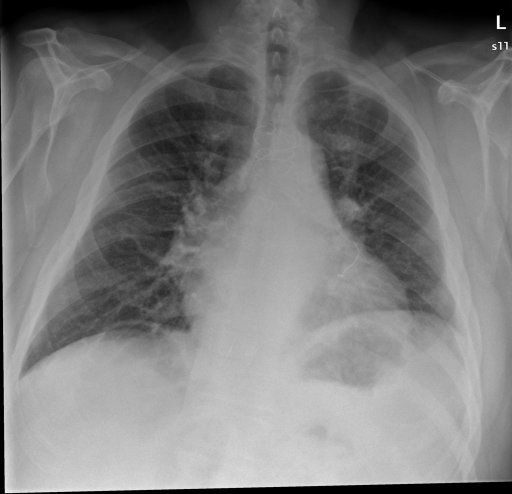

In [ ]:
print(train_captions[0])
Image.open(img_name_vector[0])

In [ ]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (224, 224))
    img = tf.keras.applications.resnet.preprocess_input(img)
    return img, image_path

In [ ]:
image_model = tf.keras.applications.ResNet101(include_top=False,
                                                weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

In [ ]:
encode_train = sorted(set(img_name_vector))
len(encode_train), len(img_name_vector)

(2369, 4728)

In [ ]:
# Feel free to change batch_size according to your system configuration
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(
  load_image, num_parallel_calls=tf.data.AUTOTUNE).batch(16)

In [ ]:
# Get unique images
encode_train = sorted(set(img_name_vector))

# Feel free to change batch_size according to your system configuration
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(
  load_image, num_parallel_calls=tf.data.AUTOTUNE).batch(16)

for img, path in image_dataset:
  batch_features = image_features_extract_model(img)
  batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))

  for bf, p in zip(batch_features, path):
    path_of_feature = p.numpy().decode("utf-8")
    np.save(path_of_feature, bf.numpy())

In [ ]:
# Find the maximum length of any caption in the dataset
def calc_max_length(tensor):
    return max(len(t) for t in tensor)

In [ ]:
# Choose the top 5000 words from the vocabulary
top_k = 5000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~')
tokenizer.fit_on_texts(train_captions)

In [ ]:
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

In [ ]:
# Create the tokenized vectors
train_seqs = tokenizer.texts_to_sequences(train_captions)

In [ ]:
# Pad each vector to the max_length of the captions
# If you do not provide a max_length value, pad_sequences calculates it automatically
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')

In [ ]:
# Calculates the max_length, which is used to store the attention weights
max_length = calc_max_length(train_seqs)

In [ ]:
img_to_cap_vector = collections.defaultdict(list)
for img, cap in zip(img_name_vector, cap_vector):
  img_to_cap_vector[img].append(cap)

# Create training and validation sets using an 80-20 split randomly.
img_keys = list(img_to_cap_vector.keys())
random.shuffle(img_keys)

slice_index = int(len(img_keys))
img_name_train_keys, img_name_val_keys = img_keys[:slice_index], img_keys[slice_index:]

img_name_train = []
cap_train = []
for imgt in img_name_train_keys:
  capt_len = len(img_to_cap_vector[imgt])
  img_name_train.extend([imgt] * capt_len)
  cap_train.extend(img_to_cap_vector[imgt])

img_name_val = []
cap_val = []
for imgv in img_name_val_keys:
  capv_len = len(img_to_cap_vector[imgv])
  img_name_val.extend([imgv] * capv_len)
  cap_val.extend(img_to_cap_vector[imgv])

In [ ]:
# Feel free to change these parameters according to your system's configuration

BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
vocab_size = top_k + 1
num_steps = len(img_name_train) // BATCH_SIZE
# Shape of the vector extracted from InceptionV3 is (64, 2048)
# These two variables represent that vector shape
features_shape = 2048
attention_features_shape = 64

In [ ]:
# Load the numpy files
def map_func(img_name, cap):
  img_tensor = np.load(img_name.decode('utf-8')+'.npy')
  return img_tensor, cap

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# Use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle and batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, features, hidden):
    # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

    # hidden shape == (batch_size, hidden_size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
    hidden_with_time_axis = tf.expand_dims(hidden, 1)

    # attention_hidden_layer shape == (batch_size, 64, units)
    attention_hidden_layer = (tf.nn.tanh(self.W1(features) +
                                         self.W2(hidden_with_time_axis)))

    # score shape == (batch_size, 64, 1)
    # This gives you an unnormalized score for each image feature.
    score = self.V(attention_hidden_layer)

    # attention_weights shape == (batch_size, 64, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [ ]:
class CNN_Encoder(tf.keras.Model):
    # Since you have already extracted the features and dumped it
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

In [ ]:
class RNN_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(RNN_Decoder, self).__init__()
    self.units = units

    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc1 = tf.keras.layers.Dense(self.units)
    self.fc2 = tf.keras.layers.Dense(vocab_size)

    self.attention = BahdanauAttention(self.units)

  def call(self, x, features, hidden):
    # defining attention as a separate model
    context_vector, attention_weights = self.attention(features, hidden)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # shape == (batch_size, max_length, hidden_size)
    x = self.fc1(output)

    # x shape == (batch_size * max_length, hidden_size)
    x = tf.reshape(x, (-1, x.shape[2]))

    # output shape == (batch_size * max_length, vocab)
    x = self.fc2(x)

    return x, state, attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))

In [ ]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

In [ ]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')


def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

In [ ]:
checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [ ]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
  # restoring the latest checkpoint in checkpoint_path
  ckpt.restore(ckpt_manager.latest_checkpoint)

In [ ]:
# adding this in a separate cell because if you run the training cell
# many times, the loss_plot array will be reset
loss_plot = []

In [ ]:
@tf.function
def train_step(img_tensor, target):
  loss = 0

  # initializing the hidden state for each batch
  # because the captions are not related from image to image
  hidden = decoder.reset_state(batch_size=target.shape[0])

  dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

  with tf.GradientTape() as tape:
      features = encoder(img_tensor)

      for i in range(1, target.shape[1]):
          # passing the features through the decoder
          predictions, hidden, _ = decoder(dec_input, features, hidden)

          loss += loss_function(target[:, i], predictions)

          # using teacher forcing
          dec_input = tf.expand_dims(target[:, i], 1)

  total_loss = (loss / int(target.shape[1]))

  trainable_variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, trainable_variables)

  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, total_loss

In [ ]:
EPOCHS = 20

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            average_batch_loss = batch_loss.numpy()/int(target.shape[1])
            print(f'Epoch {epoch+1} Batch {batch} Loss {average_batch_loss:.4f}')
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    if epoch % 5 == 0:
      ckpt_manager.save()

    print(f'Epoch {epoch+1} Loss {total_loss/num_steps:.6f}')
    print(f'Time taken for 1 epoch {time.time()-start:.2f} sec\n')

Epoch 1 Batch 0 Loss 2.2711
Epoch 1 Loss 1.346310
Time taken for 1 epoch 367.58 sec

Epoch 2 Batch 0 Loss 1.3547
Epoch 2 Loss 1.262489
Time taken for 1 epoch 77.75 sec

Epoch 3 Batch 0 Loss 1.1777
Epoch 3 Loss 0.952074
Time taken for 1 epoch 77.68 sec

Epoch 4 Batch 0 Loss 0.8871
Epoch 4 Loss 0.765056
Time taken for 1 epoch 77.59 sec

Epoch 5 Batch 0 Loss 0.7205
Epoch 5 Loss 0.663821
Time taken for 1 epoch 77.07 sec

Epoch 6 Batch 0 Loss 0.6888
Epoch 6 Loss 0.601952
Time taken for 1 epoch 77.95 sec

Epoch 7 Batch 0 Loss 0.5045
Epoch 7 Loss 0.550899
Time taken for 1 epoch 77.20 sec

Epoch 8 Batch 0 Loss 0.4810
Epoch 8 Loss 0.499110
Time taken for 1 epoch 77.49 sec

Epoch 9 Batch 0 Loss 0.4991
Epoch 9 Loss 0.450747
Time taken for 1 epoch 77.21 sec

Epoch 10 Batch 0 Loss 0.4475
Epoch 10 Loss 0.400640
Time taken for 1 epoch 77.49 sec

Epoch 11 Batch 0 Loss 0.4491
Epoch 11 Loss 0.351723
Time taken for 1 epoch 77.81 sec

Epoch 12 Batch 0 Loss 0.3254
Epoch 12 Loss 0.305767
Time taken for 1 ep

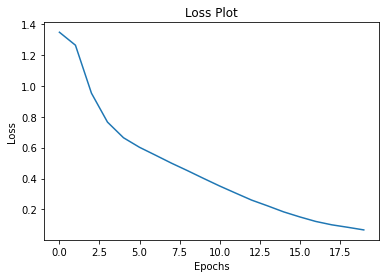

In [ ]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

In [ ]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0],
                                                 -1,
                                                 img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input,
                                                         features,
                                                         hidden)

        # attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [ ]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for i in range(len_result):
        temp_att = np.resize(attention_plot[i], (8, 8))
        grid_size = max(np.ceil(len_result/2), 2)
        ax = fig.add_subplot(grid_size, grid_size, i+1)
        ax.set_title(result[i])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

Prediction Caption: the cardiomediastinal silhouette is normal nodular interstitial markings peribronchial cuffing also elevation of the spine <end>
<start> the cardiomediastinal silhouette is normal in size and contour . streaky perihilar opacities . peribronchial cuffing also noted . no focal consolidation pneumothorax or large pleural effusion . normal <end>
{'CXR3466_IM-1683-1001.png'}


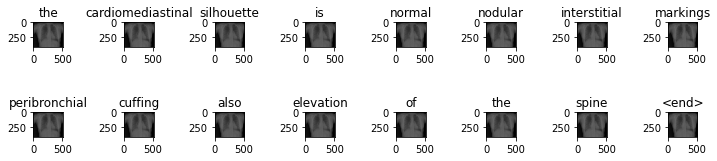

Prediction Caption: no pleural effusion or pneumothorax <end>
<start> no acute osseous abnormality . stable scattered endplate degenerative changes and osteophyte formation in the thoracic spine . normal cardiomediastinal silhouette and hilar contours . no focal area of consolidation pleural effusion or pneumothorax . <end>
{'CXR3987_IM-2041-1001.png'}


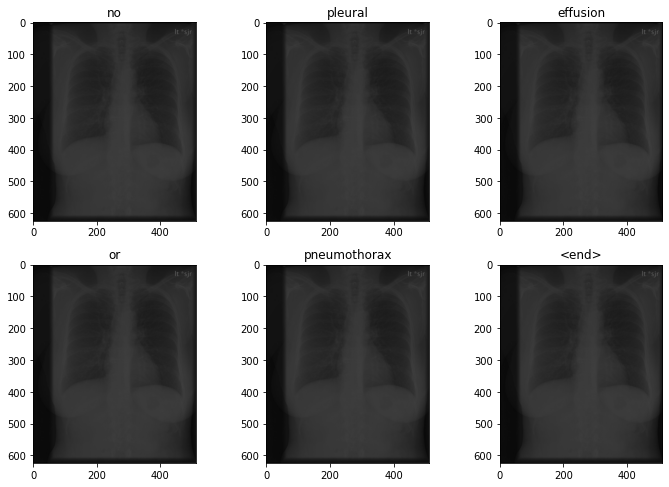

Prediction Caption: the lungs are clear no acute osseous abnormalities <end>
<start> there is increased opacity within the right upper lobe with possible mass and associated area of atelectasis or focal consolidation . the cardiac silhouette is within normal limits . opacity in the left midlung overlying the posterior left h rib may represent focal airspace disease . no pleural effusion or pneumothorax . no acute bone abnormality . <end>
{'CXR1000_IM-0003-1001.png'}


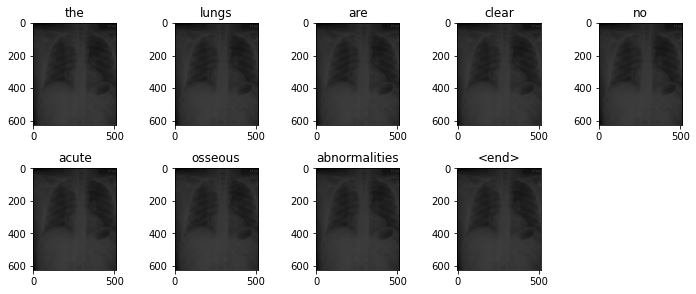

Prediction Caption: the lungs are mildly hypoinflated with technique low lung volumes are low lung volumes are low lung volumes are low lung volumes are low lung volumes are low lung volumes are low lung volumes are low lung volumes are low lung volumes are low lung volumes are low lung volumes are low lung volumes are low lung volumes are low lung volumes are low lung volumes are low lung volumes are low lung volumes are low lung volumes are low lung volumes are low lung volumes are low lung volumes are low lung volumes are low lung volumes are low lung volumes are low lung volumes are low lung volumes are low lung volumes are low lung volumes are low lung volumes are low
<start> the heart is significantly enlarged . prominent pulmonary vascularity . no focal airspace consolidation suspicious pulmonary opacity or definite pleural effusion . no pneumothorax . visualized osseous structures appear intact . <end>
{'CXR2919_IM-1321-2001.png'}


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  from ipykernel import kernelapp as app


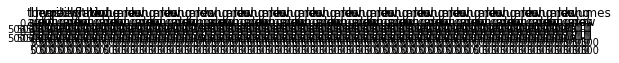

Prediction Caption: lungs are clear bilaterally cardiac and mediastinal silhouettes are normal lungs are clear without focal infiltrate there is no acute bony abnormality <end>
<start> lungs are clear bilaterally . cardiac and mediastinal silhouettes are normal . pulmonary vasculature is normal . no pneumothorax or pleural effusion . no acute bony abnormality . <end>
{'CXR2854_IM-1262-1001.png'}


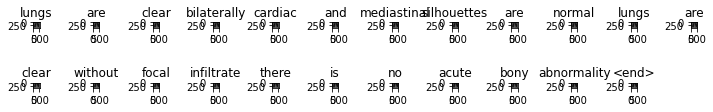

Prediction Caption: heart size and mediastinal contours appear within normal limits no focal air space opacities visualized bony structures show normal size are within normal limits no focal air space opacities pleural effusion visualized osseous structures appear intact <end>
<start> heart size and mediastinal contours appear within normal limits . pulmonary vascularity is within normal limits . no focal consolidation suspicious pulmonary opacity pneumothorax or definite pleural effusion . visualized osseous structures appear intact . <end>
{'CXR1192_IM-0129-1001.png'}


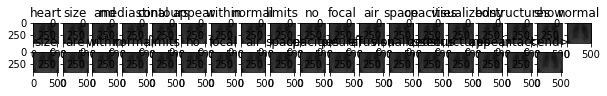

Prediction Caption: similar mild cardiomegaly the thoracic spine <end>
<start> similar mild cardiomegaly . of the pulmonary vascularity is prominent . no focal consolidations or effusions . no pneumothorax . no acute bony abnormality . <end>
{'CXR3994_IM-2045-1001.png'}


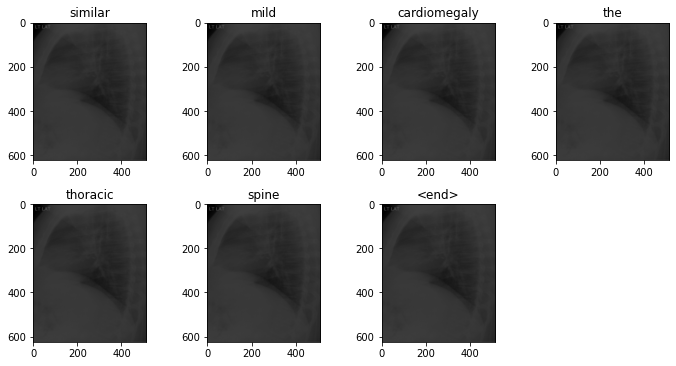

Prediction Caption: the trachea is midline sternotomy with prior osteophyte formation the heart is within normal limits <end>
<start> the trachea is midline . cardio mediastinal silhouette is normal in contour with overlying sternotomy the lungs are clear without acute infiltrate effusion or pneumothorax . the visualized bony structures reveal no fractures or dislocations . <end>
{'CXR1052_IM-0040-1001.png'}


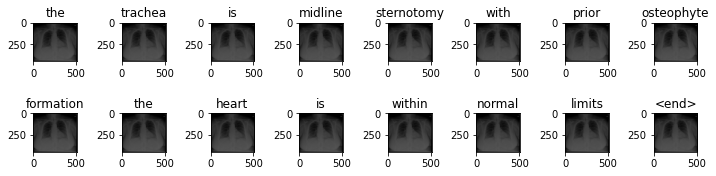

Prediction Caption: the lungs are clear without evidence of focal consolidation suspicious appearing opacity in the heart size normal stable cardiomediastinal silhouette is normal no consolidating consolidation pneumothorax or pleural effusion no acute abnormality there is no acute abnormality there is no acute abnormality <end>
<start> the lungs are clear bilaterally . specifically no evidence of focal consolidation pneumothorax or pleural effusion . cardiomediastinal silhouette is unremarkable . visualized osseous structures of the thorax are without acute abnormality . <end>
{'CXR532_IM-2140-1001.png'}


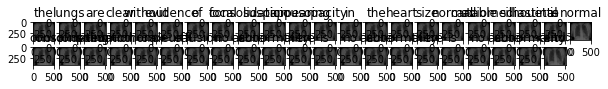

Prediction Caption: stable calcified thoracic spine hyperinflated lungs are hyperexpanded bullae are consistent with chronic lung apices no focal air space opacities opacity pleural effusion or suspicious pulmonary consolidation heart size and contour no pneumothorax or pleural effusion no suspicious pulmonary mass rib fractures <end>
<start> normal heart size . stable tortuous aorta . no pneumothorax or pleural effusion . no suspicious focal air space opacities . levoscoliosis of the thoracolumbar spine . hyperinflated lungs with flattened diaphragms are consistent with emphysematous lung changes . prior granulomatous disease . <end>
{'CXR1056_IM-0040-1002.png'}


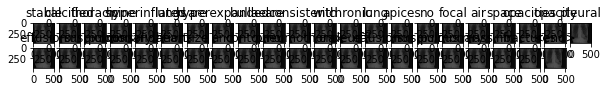

In [ ]:
annotations = open("/content/drive/MyDrive/Medical Image Reporting/testing_final.txt").read().split('\n')
image_path_to_caption = collections.defaultdict(list)
for idx in  range(len(annotations)-1):
  id_capt = annotations[idx].split("#")
  caption = f"<start> {id_capt[1]} <end>"
  image_path = f"/content/drive/MyDrive/Medical Image Reporting/NLMCXR_png/{id_capt[0][:len(id_capt[0])]}"
  result, attention_plot = evaluate(image_path)
  print('Prediction Caption:', ' '.join(result))
  print(caption)
  print({id_capt[0][:len(id_capt[0])]})
  plot_attention(image_path, result, attention_plot)


Real Caption: <start> the heart is normal in size the mediastinum is unremarkable subtle increased opacity of right mid hemithorax related to superimposed soft tissues the lungs are otherwise clear there is no pleural effusion or pneumothorax <end>
Prediction Caption: normal heart size normal cardiomediastinal silhouette normal <end>


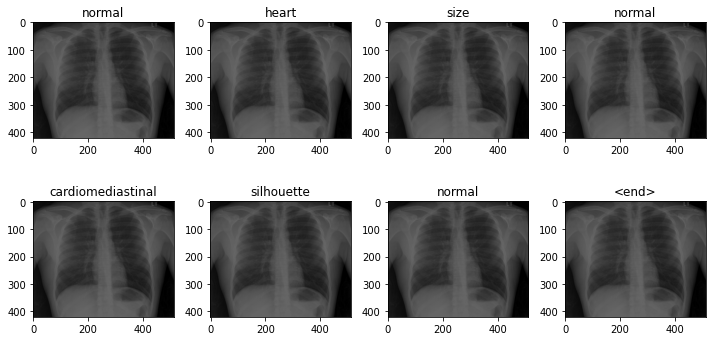

In [ ]:
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tokenizer.index_word[i]
                        for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

print('Real Caption:', real_caption)
print('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)

In [ ]:
test_imgs = [
            '/content/drive/MyDrive/Medical Image Reporting/upload/01E392EE-69F9-4E33-BFCE-E5C968654078.jpeg',
            '/content/drive/MyDrive/Medical Image Reporting/upload/1-s2.0-S0929664620300449-gr2_lrg-a.jpg',
            '/content/drive/MyDrive/Medical Image Reporting/upload/1-s2.0-S0929664620300449-gr2_lrg-c.jpg',
             '/content/drive/MyDrive/Medical Image Reporting/upload/1.CXRCTThoraximagesofCOVID-19fromSingapore.pdf-000-fig1a.png'

]

Prediction Caption: the distal aortic calcifications are present in the right humerus fracture of focal infiltrate there is right ankle there are low lung volumes elevated pleural effusion or pneumothorax stable calcified appearance of consolidation large pleural effusions or pneumothorax is underlying tortuosity of the thoracolumbar by be related to suggest large pleural effusion or free of fracture of active anterolateral thickening probable large effusion or pneumothorax mild cardiomegaly is noted in the bony thorax are mildly enlarged no pleural effusion seen a large pleural effusion seen there is elevation of the ascending spondylosis <end>


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  from ipykernel import kernelapp as app


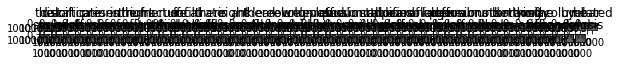

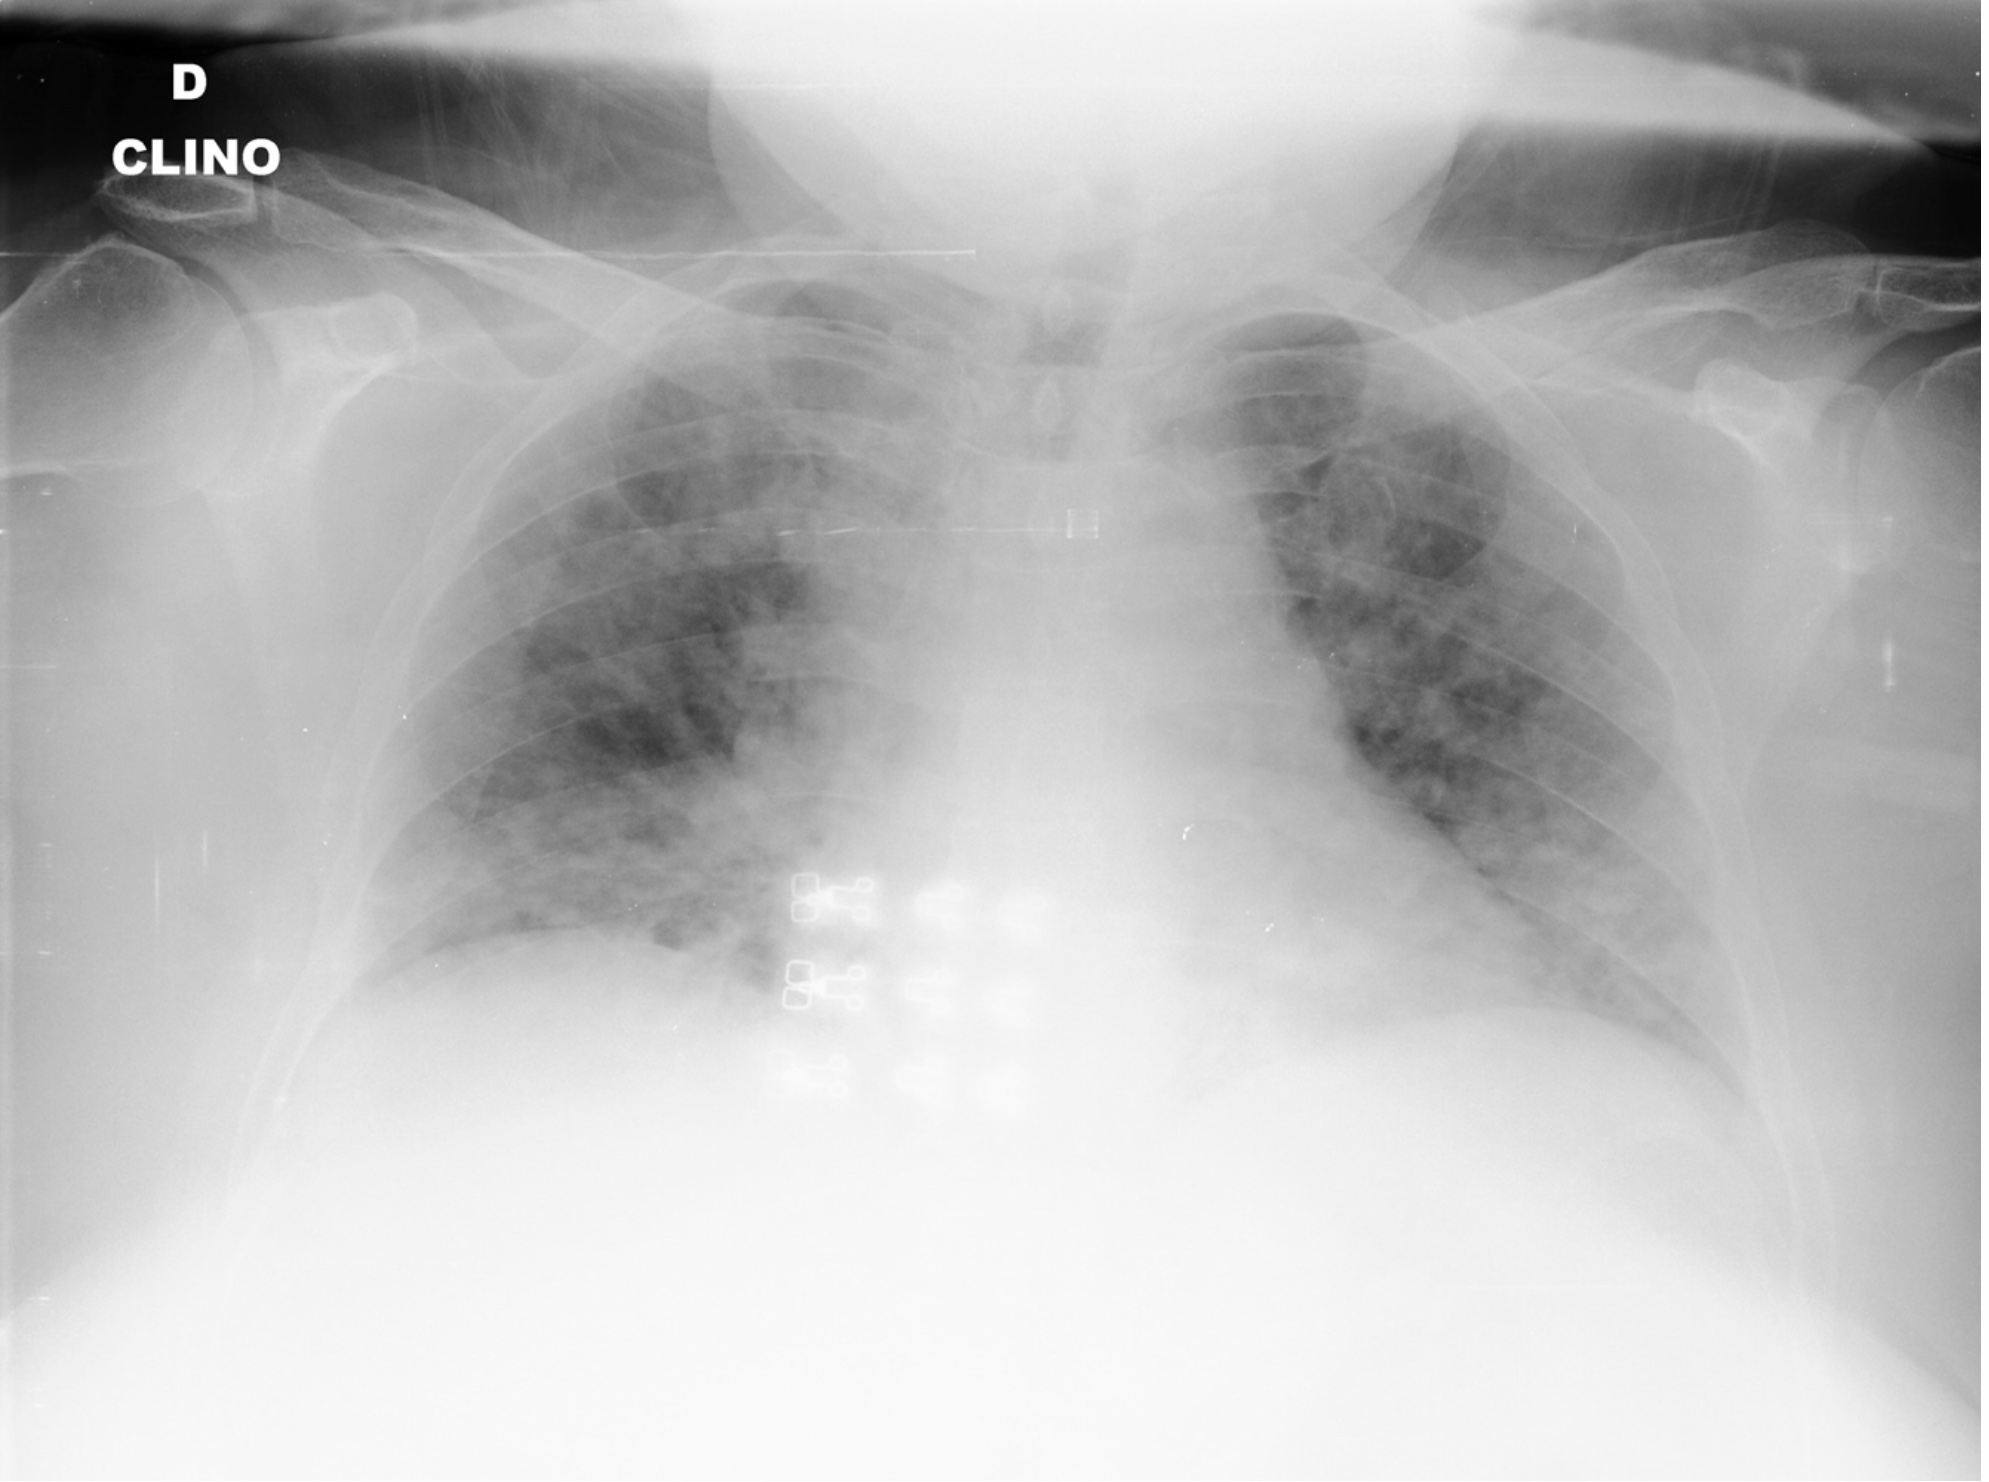

In [ ]:

result, attention_plot = evaluate(test_imgs[0])
print('Prediction Caption:', ' '.join(result))
plot_attention(test_imgs[0], result, attention_plot)
  # opening the image
Image.open(test_imgs[0])


Prediction Caption: normal heart size normal no focal consolidation pneumothorax or pleural effusion normal mediastinal contours are within normal limits normal cardiomediastinal contours are normal pulmonary vasculature are unremarkable the trachea normal lung apices or scar seen in the left cardiomediastinal silhouette is normal pulmonary vasculature are normal pulmonary vasculature are normal pleural spaces are clear and expanded and hyperexpanded lungs and pleural spaces are clear and clear the lungs and mediastinal silhouettes are normal pulmonary vasculature are normal pulmonary vasculature are normal pulmonary vascularity are within normal limits no pneumothorax or pleural effusion is seen projecting over the lungs are clear otherwise no pneumothorax or pleural effusion normal limits and contour the lungs are free of focal airspace consolidation heart size is normal size and


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  from ipykernel import kernelapp as app


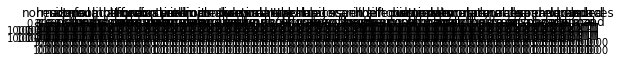

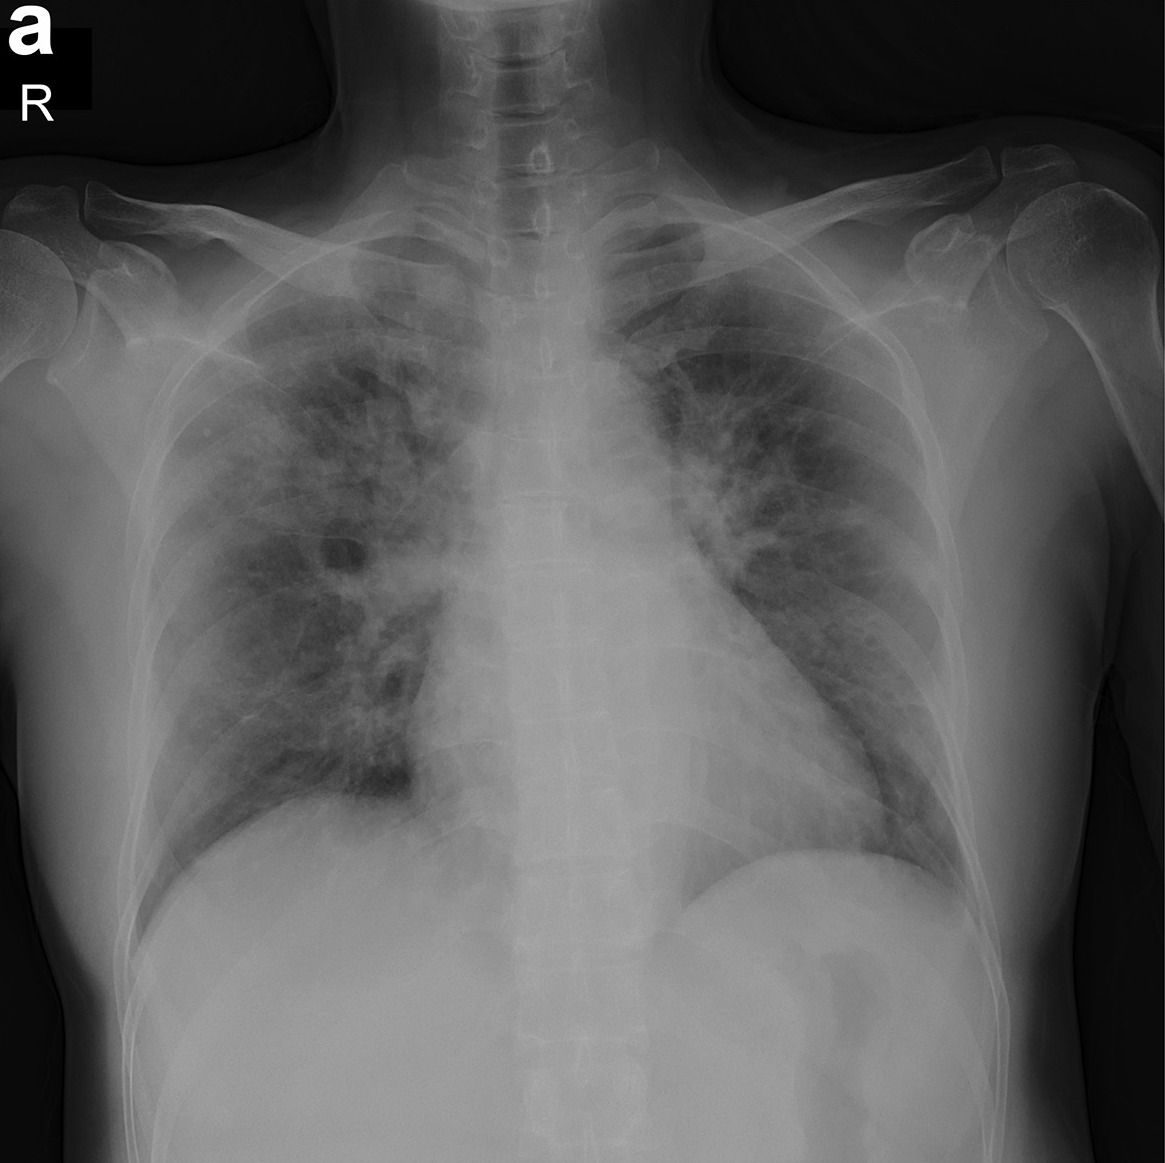

In [ ]:
result, attention_plot = evaluate(test_imgs[1])
print('Prediction Caption:', ' '.join(result))
plot_attention(test_imgs[1], result, attention_plot)
  # opening the image
Image.open(test_imgs[1])


Prediction Caption: negative for focal airspace consolidation no pleural effusion bony thorax is midline the frontal and lateral views of the lumbar spine <end>


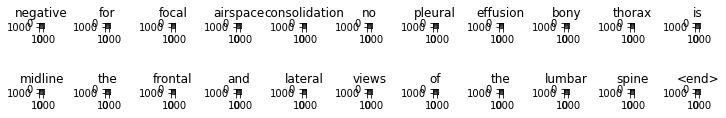

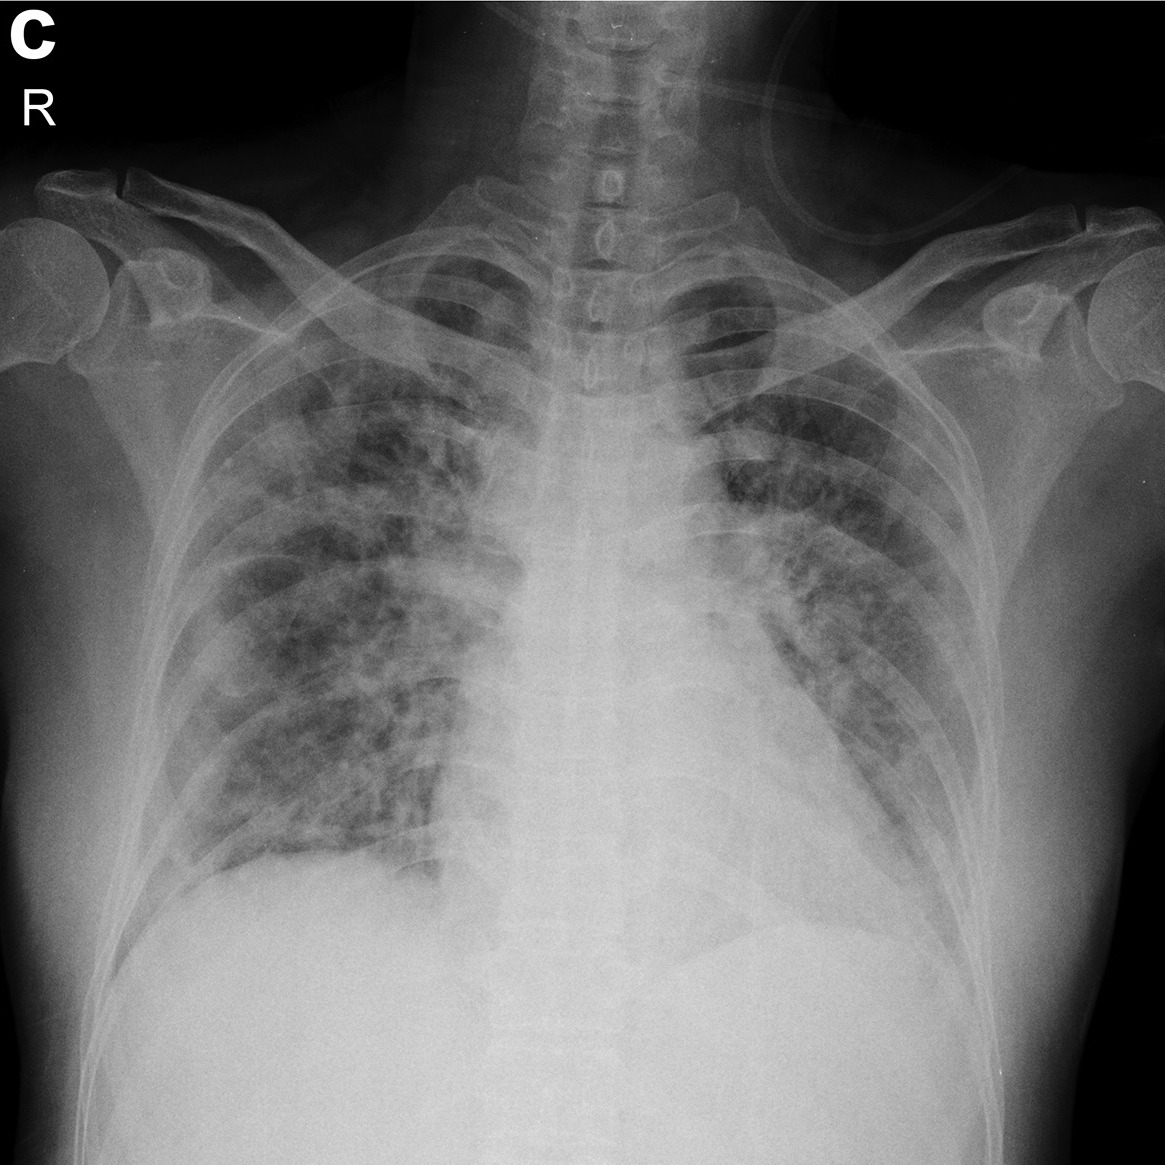

In [ ]:
result, attention_plot = evaluate(test_imgs[2])
print('Prediction Caption:', ' '.join(result))
plot_attention(test_imgs[2], result, attention_plot)
  # opening the image
Image.open(test_imgs[2])


Prediction Caption: the heart size within normal limits granulomatous disease no focal consolidation nodules in appearance the lungs are well aerated there is a focal atelectasis the lungs and mediastinum normal in size the lungs and costophrenic are not significantly increased no pneumothorax no cavitary lesions normal in size the lungs are clear no focal consolidation pleural effusion normal heart size is normal <end>


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  from ipykernel import kernelapp as app


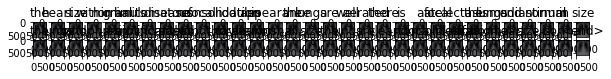

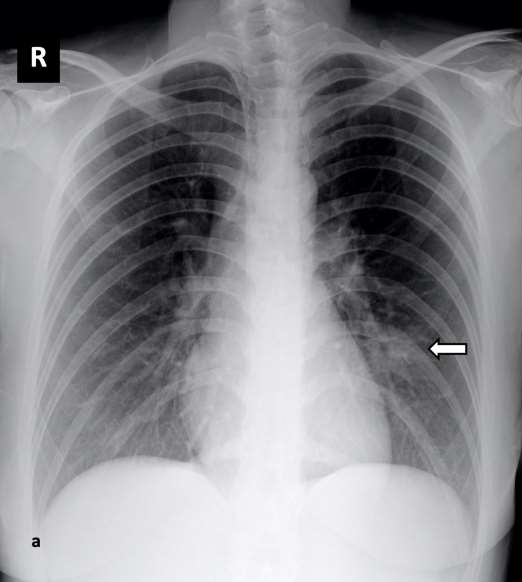

In [ ]:
result, attention_plot = evaluate(test_imgs[3])
print('Prediction Caption:', ' '.join(result))
plot_attention(test_imgs[3], result, attention_plot)
  # opening the image
Image.open(test_imgs[3])


In [ ]:
result, attention_plot = evaluate(test_imgs[4])
print('Prediction Caption:', ' '.join(result))
plot_attention(test_imgs[4], result, attention_plot)
  # opening the image
Image.open(test_imgs[4])


IndexError: ignored

In [ ]:
result, attention_plot = evaluate(test_imgs[5])
print('Prediction Caption:', ' '.join(result))
plot_attention(test_imgs[5], result, attention_plot)
  # opening the image
Image.open(test_imgs[5])


In [ ]:
image_url = '/content/drive/MyDrive/Medical Image Reporting/upload/1.CXRCTThoraximagesofCOVID-19fromSingapore.pdf-001-fig2b.png'
image_extension = image_url[-4:]
image_path = '/content/drive/MyDrive/Medical Image Reporting/upload/1.CXRCTThoraximagesofCOVID-19fromSingapore.pdf-001-fig2b.png'

result, attention_plot = evaluate(image_path)
print('Prediction Caption:', ' '.join(result))
plot_attention(image_path, result, attention_plot)
# opening the image
Image.open(image_path)